#  AI CA3 
# Data processing and bayesian networks
## Name: Fatemeh Naeinian

### Student ID: 810099018


## Definition of project:

Text classification is useful in lots of aspects, for instance: spam email recognition, automatic book classification and ...

The goal of this project is to classify news based on description. We already have six main categories: Health, Political, Sports, Technology, Art and Accidents.
 
with a strategy called bag of words model will be trained , then for evaulation we use test data. And measure accuracy, recall, and precision for every category.
Ultimately we label data in test.csv based on the bag of words we've gained previously.


In [ ]:
!pip install hazm
!pip3 install parsivar
!pip install wordcloud
!pip install wordcloud-fa

In [2]:
import numpy as np
import pandas as pd
import hazm
import parsivar
from hazm import *
import copy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud_fa import WordCloudFa
import random
from bidi.algorithm import get_display
from arabic_reshaper import reshape
import operator
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


**phase 1**

In [4]:
train = pd.read_csv('/content/gdrive/MyDrive/Dataset/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Dataset/test.csv')

with open('/content/gdrive/MyDrive/Dataset/persian.txt') as f:
  stop_words = []
  [stop_words.append(line.strip()) for line in f.readlines()]

In [5]:
train.head()

,label,content
0,فناوری,گزارش های منتشر شده حاکی از آن است که کاربران ...
1,ورزشی,سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2,حوادث,مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3,فناوری,یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4,سلامت,دانشمندان در جدیدترین مطالعات خود اثرات جدید و...


# **Preprocess** 

Every context in training data should be preprocessed in order to extract main words and to calculate probability of words per categories. For preprocessing hazm and parsivar library is used. preprocessing steps are shown below:



1. normalizer : This function helps to normalize sentences. For example, it deletes extra spaces and convert english numbers to persian numbers.
2. tokenizer : This function has two modes: word tokenize and sentence tokenize. sentence tokenize splits each sentence with "." and word tokenize splits each words. So you can process each words easier.
3. lemmatizer : In computational linguistics, lemmatisation is the algorithmic process of determining the lemma of a word based on its intended meaning. Unlike stemming, lemmatisation depends on correctly identifying the intended part of speech and meaning of a word in a sentence. In our project lemmatization works a bit better with better accuracy.
4. stemmer : algorithms work by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found in an inflected word. We don't use this method in this project because it doesn't work well in persian.
5. stop_words : The words which are generally filtered out before processing a natural language are called stop words. These are actually the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text.




In [6]:
def remove_signs(word):
  for char in '(),.<>:;#$%&*!~»«،؛؟][\}?{’۱۲۳۴۵۶۷۸۹۰1234567890-_':
    word = word.replace(char,'')
  return word

def preprocess(df):
  tokenizer = parsivar.Tokenizer()
  normalizer = hazm.Normalizer()
  stemmer = parsivar.FindStems()
  lemmatizer = hazm.Lemmatizer()
  new_df = copy.copy(df)
  new_df['content'] = ""

  for i in range(df['content'].shape[0]):
    new_df['content'][i] = []
    df['content'][i] = tokenizer.tokenize_words(normalizer.normalize(df['content'][i]))
    for j in range(len(df['content'][i])):
      # df['content'][i][j] = stemmer.convert_to_stem(df['content'][i][j]).split(r'#&')[0]
      df['content'][i][j] = lemmatizer.lemmatize(df['content'][i][j]).split(r'#')[0]
      df['content'][i][j] = remove_signs(df['content'][i][j])
      if df['content'][i][j] not in stop_words:
        new_df['content'][i].append(df['content'][i][j])
      new_df['content'][i] = list(filter(None, new_df['content'][i]))
  return new_df

In [7]:
new_train = preprocess(train)
new_test = preprocess(test)

In [8]:
new_train.head()

,label,content
0,فناوری,"[گزارش, منتشر, حاکی, کاربر, تلگرام, مناطق, جها..."
1,ورزشی,"[سوپر, استار, سینما, قهرمان, ووشو, کونگ‌فو, حض..."
2,حوادث,"[مدیرعامل, شرکت, عمران, آب, کیش, فوت, نفر, آتش..."
3,فناوری,"[نوجوان, انگلیسی, اتهام, هک, حساب, کاربر, ایمی..."
4,سلامت,"[دانشمند, مطالعات, اثرات, ویروس, کرونا, گوش, ک..."


In [9]:
new_test.head()

,label,content
0,فناوری,"[لیس, شرکت, مجاز, ثبت, سفارش, ارائه, فروش, تلف..."
1,فرهنگی/هنری,"[استاد, علم, قرائت, قرآن, کریم, ریشه, موسیقی, ..."
2,حوادث,"[آتش, سوزی‌های, زنجیره, جنگل, زاگرس, استان, ای..."
3,فناوری,"[سرویس‌های, iMassage, Facetime, محصولات, شرکت,..."
4,حوادث,"[دادستان, انقلاب, یاسوج, دلار, جعلی, خودرو, شه..."


In [10]:
all_words = []

for i in range(new_train['content'].shape[0]):
  all_words += new_train['content'][i]

print('number of all words',len(all_words))
print('number of uniqe words',len([*set(all_words)]))

number of all words 1751179
number of uniqe words 63111


# wordcloud

This method is used to see the most repeated words in a list. So it gets easier to analyse the results.

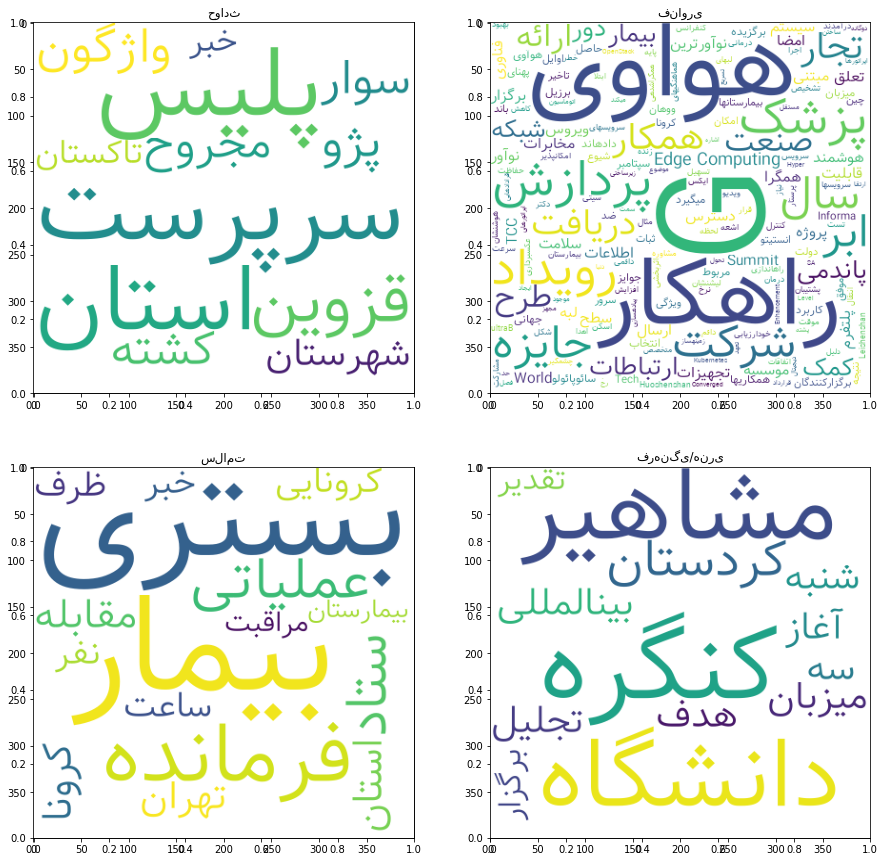

In [11]:
fig, axs = plt.subplots(2,2, figsize=(15, 15))
for i in range(4):
  fig.add_subplot(2, 2, i+1)
  rnd_indx = random.randint(0,new_train['content'].shape[0])
  concat_words = ''
  concat_words += " ".join(new_train['content'][rnd_indx])+" "
  wordcloud = WordCloudFa(width=400, height=400, background_color='white').generate(concat_words)

  image = wordcloud.to_image()
  plt.imshow(image, aspect='auto')
  plt.title(new_train['label'][rnd_indx])

# bag or words model

Bag of words is a model which is insensitive to word orders. it uses bayesian networks and naive bayes to calculate probabilites. In our model we have 4 types of probabilites:

1. Posterier: p(c|x): If we have the x as a word in our text, what is the probability of c category for this text.
2. Prior: p(c): the probability of c as category (calculated based on training data).
3. Likelihood: p(x|c): If we know that c is category of current text, what is the probability that this text contains word x.
4. Evidence: p(x): the probability of existance of x as a word in text. We devide the number of current word to total words to calculate p(x) for every x.


At the end we use **p(c|X = {x1,x2,x3,...}) = p(x1|c)p(x2|c) ..... p(c)** to evaluate.





# Bigrams

A bigram or digram is a sequence of two adjacent elements from a string of tokens, which helps us to understand the meaning of a word by using other previous or next word.

for example  "شیر در باغ وحش زندگی میکند." and "مصرف شیر برای سلامتی مفید است."

"شیر" has two different meaning and can be underestood from other words.

In these sentences bigrams can identify the meaning.


# Additive Smoothing

This is introduced to solve the problem of zero probability. With naive bayes, if a word isn't in a training class, probability of belonging to that class will be zero. In additive smoothing, while counting the number of a word, 1 will be added to that number. This will help to prevent from probability of zero.

\begin{equation}
P(w_i,c) = \dfrac{count(w_i,c)+1}{Σcount(w,c)+|V|}
\end{equation}

If count becomes zero, there still will be a little probability.

# Evaluation

Question 7)

  Precision doesn't care about the data which has that label but is identified with another label. Recall probelm is opposite of precision. Recall doesn't care about the data which is identified with this label wrongly.
For example, if we have an unbalance dataset for cancer, a few of them may have a positive label. So if we calculate precision for positive cancer it will be near 100% and recall will be under 10%.
 
Question 8) 

  F1 score is a value that compromises between Recall and Precision by taking the harmonic mean between them. The reason we use the harmonic mean is to amplify the effects of extreme values. When a dataset is unbalanced accuracy may be high but with F1 score we can see how much this model is good.


Question 9) 


*   Micro average: it is similar to accuracy.
*   Macro average: this is average of F1 scores for all classes. There are macro-recall which is average of recalls and macro-precision which is average of precisions. 
*   Weighted average: in weighted-average F1-score, number of data from each class will be a weight for calculating average.



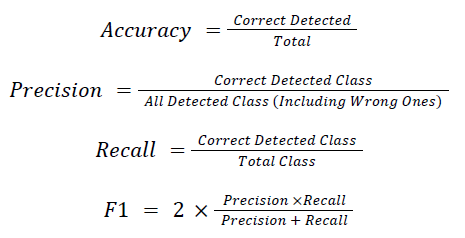

In [15]:
from pandas._libs.lib import fast_unique_multiple_list_gen
class Classifier:
  def __init__(self):
    self.class_words = dict()
    self.class_count = {}
    self.class_frequency = {}
    self.total_words = 0

  def create_words_dictionary(self, df):
    for idx in df.index:
      target = df['label'][idx]

      if target not in self.class_count:
        self.class_count[target] = 0

      if target not in self.class_frequency:
        self.class_frequency[target] = 0

      if target not in self.class_words:
        self.class_words[target] = dict()

      self.class_frequency[target] += 1

      for word in df['content'][idx]:
        if word not in self.class_words[target]:
          self.class_words[target][word] = 0
        self.class_count[target] += 1
        self.total_words += 1
        self.class_words[target][word] += 1 
    

  def predict(self, test, smoothing):
    test_predicted_class = []
    for idx in test.index:
      class_probs = dict()
      for target in list(self.class_words.keys()):
        class_probs[target] = np.log(self.class_frequency[target]/sum(self.class_frequency.values()))
        for word in test['content'][idx]:
          if smoothing:
            class_probs[target] += (np.log(self.class_words[target].get(word,0)+1)-np.log(self.class_count[target]+len(self.class_words[target])))
          else:
            class_probs[target] += (np.log(self.class_words[target].get(word,0))-np.log(self.class_count[target]))
      test_predicted_class.append(max(class_probs.items(), key=operator.itemgetter(1))[0])
    return test_predicted_class

  def top_words(self, n):
    best_words = dict()
    for c in list(self.class_words.keys()):
        best_words[c] = dict(sorted(self.class_words[c].items(), key=operator.itemgetter(1), reverse=True)[:n])
    return best_words

In [16]:
def model_evaluation(test_predicted_labels, test):
  classes = list(set(test['label'].values))

  all_correct_gueses = 0
  for idx in test.index:
    if test_predicted_labels[idx] == test['label'][idx]:
      all_correct_gueses += 1
  accuracy = all_correct_gueses / len(test_predicted_labels)

  precision = []
  for label in classes:
    count_label = 0
    correct_predict = 0
    for idx in test.index:
      if test_predicted_labels[idx] == label:
        count_label += 1
        if test_predicted_labels[idx] == test['label'][idx]:
          correct_predict += 1
    precision.append(correct_predict/count_label)

  recall = []
  for label in classes:
    count_true_label = 0
    correct_predict = 0
    for idx in test.index:
      if test['label'][idx] == label:
        count_true_label += 1
        if test_predicted_labels[idx] == test['label'][idx]:
          correct_predict += 1
    recall.append(correct_predict/count_true_label)

  F1 = []
  for i in range(len(recall)):
    F1.append(2*recall[i]*precision[i]/(recall[i]+precision[i]))
  print(F1)

  weighted = 0
  for i in range(len(F1)):
    weighted += F1[i] * test['label'].to_list().count(classes[i])
  weighted = weighted/len(test['label'])

  cols = ['Precision', 'Recall','F1-score','Accuracy','Macro Avg','Micro Avg', 'Weighted Avg']
  result_df = pd.DataFrame('-', index = cols, columns = [classes[0], classes[1], classes[2], classes[3], classes[4], classes[5],'All Classes'])
  idx = [0, 1, 2, 3, 4, 5]
  for class_,i in zip(classes,idx):
      result_df.loc['Precision' , class_] = precision[i]
      result_df.loc['Recall' , class_] = recall[i]
      result_df.loc['F1-score' , class_] = F1[i]
  result_df.loc['Accuracy' , 'All Classes'] = accuracy
  result_df.loc['Macro Avg' , 'All Classes'] = sum(F1)/len(F1)
  result_df.loc['Micro Avg' , 'All Classes'] = accuracy
  result_df.loc['Weighted Avg' , 'All Classes'] = weighted
  display(result_df)

In [17]:
def plot_top_words(best_words):
    plt.figure(figsize=(15, 8))
    for i, c in enumerate(best_words):
        plt.subplot(2, 3, i+1)
        plt.gca().set_title(get_display(reshape(c)))
        plt.bar([get_display(reshape(label)) for label in best_words[c].keys()], best_words[c].values(), color='g')
    plt.show()

In [18]:
model = Classifier()
model.create_words_dictionary(new_train)

# Top 5 words of each class

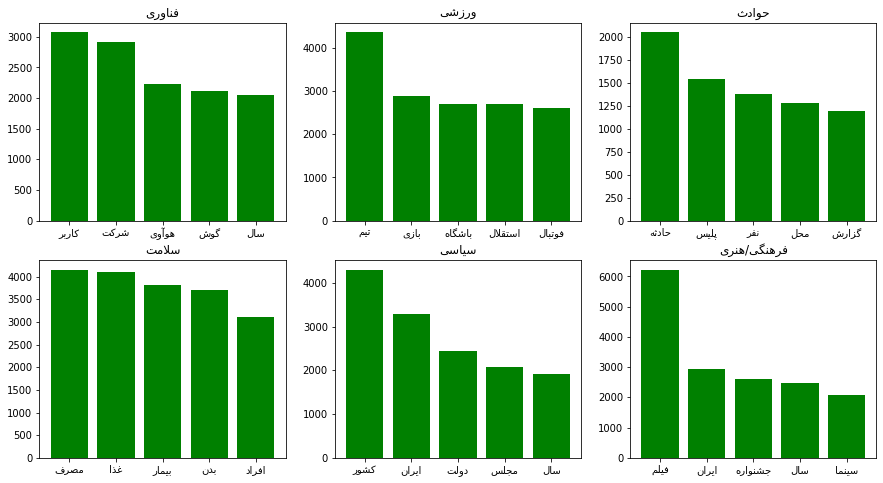

In [19]:
plot_top_words(model.top_words(5))

In [20]:
test_predicted_labels = model.predict(new_test , smoothing=False)
model_evaluation(test_predicted_labels, new_test)

<ipython-input-15-ef46c199c665>:42: RuntimeWarning: divide by zero encountered in log
  class_probs[target] += (np.log(self.class_words[target].get(word,0))-np.log(self.class_count[target]))


[0.36363636363636365, 0.240343347639485, 0.31024930747922436, 0.33480176211453744, 0.3448275862068966, 0.22772277227722773]


,سیاسی,حوادث,فناوری,فرهنگی/هنری,ورزشی,سلامت,All Classes
Precision,0.867925,0.848485,0.183607,0.808511,0.952381,0.92,-
Recall,0.23,0.14,1.0,0.211111,0.210526,0.129944,-
F1-score,0.363636,0.240343,0.310249,0.334802,0.344828,0.227723,-
Accuracy,-,-,-,-,-,-,0.307623
Macro Avg,-,-,-,-,-,-,0.303597
Micro Avg,-,-,-,-,-,-,0.307623
Weighted Avg,-,-,-,-,-,-,0.304042


In [21]:
test_predicted_labels2 = model.predict(new_test , smoothing=True)
model_evaluation(test_predicted_labels2, new_test)

[0.9134615384615385, 0.9326923076923077, 0.9390243902439025, 0.9212827988338192, 0.9814323607427056, 0.9542857142857143]


,سیاسی,حوادث,فناوری,فرهنگی/هنری,ورزشی,سلامت,All Classes
Precision,0.87963,0.898148,0.9625,0.969325,0.989305,0.965318,-
Recall,0.95,0.97,0.916667,0.877778,0.973684,0.943503,-
F1-score,0.913462,0.932692,0.939024,0.921283,0.981432,0.954286,-
Accuracy,-,-,-,-,-,-,0.93991
Macro Avg,-,-,-,-,-,-,0.940363
Micro Avg,-,-,-,-,-,-,0.93991
Weighted Avg,-,-,-,-,-,-,0.940088


With additive smoothing all of the evaluating parameters increase. Without additive smoothing accuracy is 30% and with additive smoothing it becomes 94%. 

# 5 wrong predicted labels

We can see the words in these data are more frequent in the predicted label, but here the news is different from the predicted label. Another thing is the number of words in these data are more than usual, So chance of misclassification increases.

In [22]:
n = 5
test_df = pd.read_csv('/content/gdrive/MyDrive/Dataset/test.csv')
labels = new_test["label"].to_list()
count = 0
for i in range(len(labels)):
    if test_predicted_labels2[i] != labels[i]:
        print("index is ",i)
        print("true label:", labels[i],"\n predicted label:", test_predicted_labels2[i])
        print("initial content:\n", test_df["content"].to_list()[i])
        print("preprocessed content:\n", new_test["content"].to_list()[i])
        count+=1
        if(count == n):
            break

index is  30
true label: فرهنگی/هنری 
 predicted label: سیاسی
initial content:
 - چهارشنبه اول تیر 1401 اتفاق نادر و جالبی رخ داد که قطعا به صورت تصادفی و بدون برنامه‌ریزی و اطلاع قبلی بوده است: این که به شکل کاملا هم‌زمان در محل انجمن صنفی روزنامه‌نگاران استان تهران از رونمایی شد و در صدا‌و‌سیما و در جمع معاونان سازمان هم از کلیات « ».   اگرچه سه واژۀ در هر دو مشترک‌اند اما هیچ ربط و شباهتی به هم ندارند. چرا که در اولی منظور از سند است و در دومی سند (در حالی که به تعبیر دکتر وب‌2 را هم پشت سر گذاشته و به زودی وارد وب‌3 خواهیم شد) و خود رادیو و تلویزیون دیگر رسانۀ مدرن نیست و به تعبیری رسانۀ تلویزیون در معنی عام و جهانی نه مشخصا صدا و سیما هر چند در ایران همچنان رایگان‌ترین و گسترده‌ترین امکان وقت‌گذرانی و ارتباطی است. (رایگان از جهت پرداخت حق اشتراک وگرنه بودجۀ آن از جیب ملت تأمین می‌شود). در اولی منظور از رسانه واقعا رسانه است. یعنی بدون بودجۀ حکومتی و مخاطب‌محور و در دومی به جز تعبیر «رسانه ملی» در باقی موارد ترجیح می‌دهند از مفاهیم ایدیولوژیک استفاده کنند و آن را در واقع عرصۀ جنگ م